<a href="https://colab.research.google.com/github/Badhrinath123/Lane-line-Segmentation/blob/main/LLS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Path to your ZIP file in Drive
zip_path = '/content/drive/MyDrive/archive (5).zip'  # Adjust this path as needed
extract_to = '/content/bdd100k'

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✅ Extracted to: {extract_to}")


✅ Extracted to: /content/bdd100k


In [4]:
def print_structure(start_path, max_depth=2):
    for root, dirs, files in os.walk(start_path):
        depth = root[len(start_path):].count(os.sep)
        if depth > max_depth:
            continue
        indent = '  ' * depth
        print(f"{indent}{os.path.basename(root)}/")
        subindent = '  ' * (depth + 1)
        for f in files[:5]:  # print only first 5 files for brevity
            print(f"{subindent}{f}")

# Run this
print_structure('/content/bdd100k')


bdd100k/
  val/
    annotations/
      bdd100k_labels_images_val.json
    images/
      b75cb43c-159062d9.jpg
      bcaf73c1-a0f73960.jpg
      b3d0d68d-cc5961d6.jpg
      c174b1bd-6d940899.jpg
      c8ef6dea-eea7d4cd.jpg
  test/
    ebb8bf7a-2a5790e8.jpg
    e423c53f-e5ad24fc.jpg
    d0d1cb43-ba593ea3.jpg
    efd3ebc5-287e5781.jpg
    f8e4b7ee-653354f2.jpg
  train/
    annotations/
      bdd100k_labels_images_train.json
    images/
      8193928d-07f92e43.jpg
      4a0d84c6-dbe2daa0.jpg
      7c1cda36-8912fa54.jpg
      44e0d5e3-6863c34c.jpg
      6038f2cb-dc774165.jpg


In [10]:
import json

root_dir = '/content/bdd100k'
train_img_dir = os.path.join(root_dir, 'train/images')
val_img_dir = os.path.join(root_dir, 'val/images')
train_ann_file = os.path.join(root_dir, 'train/annotations/bdd100k_labels_images_train.json')
val_ann_file = os.path.join(root_dir, 'val/annotations/bdd100k_labels_images_val.json')

with open(train_ann_file, 'r') as f:
    train_anns = json.load(f)
with open(val_ann_file, 'r') as f:
    val_anns = json.load(f)

# Reduce for fast testing
train_anns = train_anns[:200]
val_anns = val_anns[:50]


In [11]:
import numpy as np
import cv2

def create_lane_mask(image_shape, labels):
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    for obj in labels:
        if obj['category'] == 'lane':
            for poly in obj.get('poly2d', []):
                points = poly['vertices']
                for i in range(len(points) - 1):
                    pt1 = tuple(map(int, points[i]))
                    pt2 = tuple(map(int, points[i + 1]))
                    cv2.line(mask, pt1, pt2, color=255, thickness=3)

    return mask


In [12]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch

class LaneDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        item = self.annotations[idx]
        img_path = os.path.join(self.img_dir, item['name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_shape = image.shape
        image = cv2.resize(image, (128, 128))

        mask = create_lane_mask(image_shape, item.get('labels', []))
        mask = cv2.resize(mask, (128, 128))
        mask = np.expand_dims(mask, axis=0) / 255.0

        if self.transform:
            image = self.transform(image)

        return image, torch.from_numpy(mask).float()

transform = transforms.Compose([transforms.ToTensor()])
train_data = LaneDataset(train_anns, train_img_dir, transform)
val_data = LaneDataset(val_anns, val_img_dir, transform)


In [16]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)

        self.pool = nn.MaxPool2d(2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.up2(e3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return torch.sigmoid(self.out(d1))


In [17]:
from torch.utils.data import DataLoader
from tqdm import tqdm

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

def train_model(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [18]:
for epoch in range(10):
    loss = train_model(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Training: 100%|██████████| 50/50 [01:42<00:00,  2.06s/it]


Epoch 1, Loss: 0.4975


Training: 100%|██████████| 50/50 [01:40<00:00,  2.00s/it]


Epoch 2, Loss: 0.3691


Training: 100%|██████████| 50/50 [01:39<00:00,  2.00s/it]


Epoch 3, Loss: 0.3070


Training: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


Epoch 4, Loss: 0.2735


Training: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


Epoch 5, Loss: 0.2471


Training: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


Epoch 6, Loss: 0.2261


Training: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


Epoch 7, Loss: 0.2086


Training: 100%|██████████| 50/50 [01:39<00:00,  2.00s/it]


Epoch 8, Loss: 0.1916


Training: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


Epoch 9, Loss: 0.1787


Training: 100%|██████████| 50/50 [01:40<00:00,  2.02s/it]

Epoch 10, Loss: 0.1665


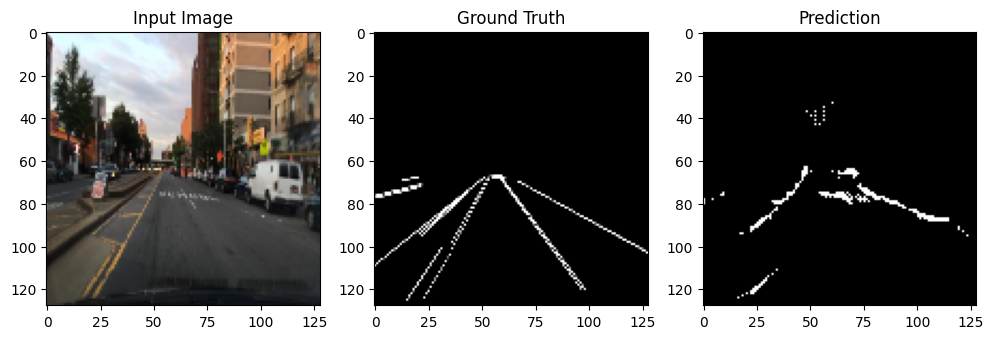

In [32]:
import matplotlib.pyplot as plt

def show_predictions(model, dataset, device, idx=0, threshold=0.2):
    model.eval()
    img, mask = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).squeeze().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred > threshold, cmap='gray')
    plt.title("Prediction")
    plt.show()

show_predictions(model, val_data, device, idx=0)


Prediction #1


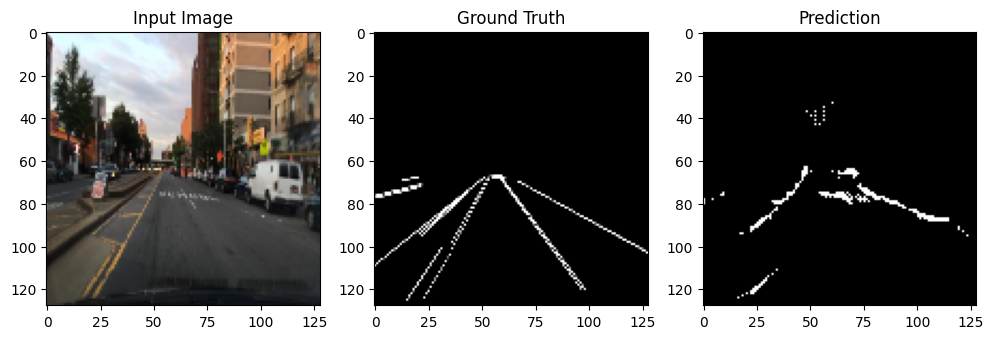

Prediction #2


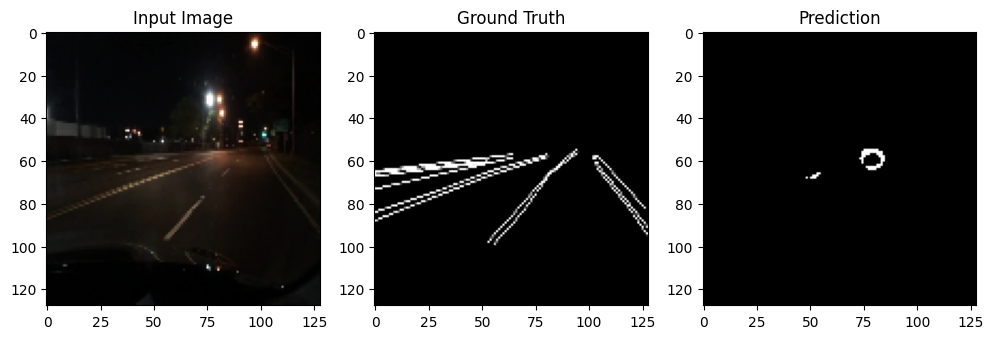

Prediction #3


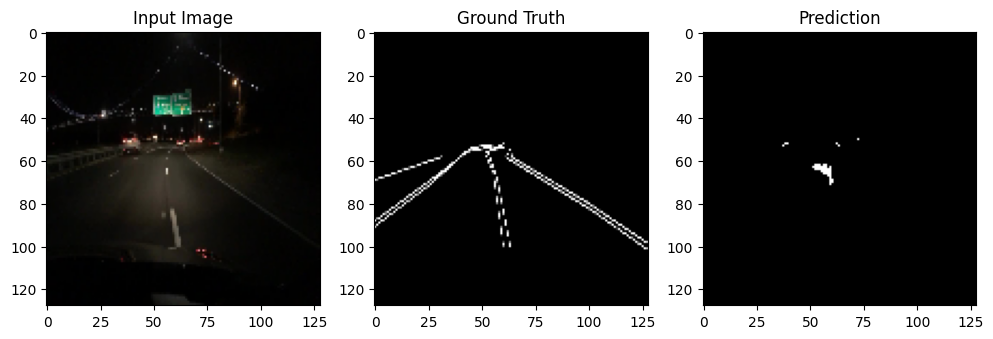

Prediction #4


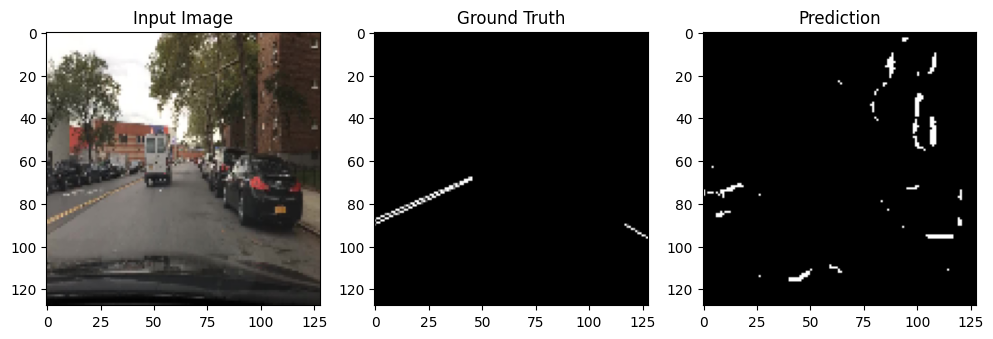

Prediction #5


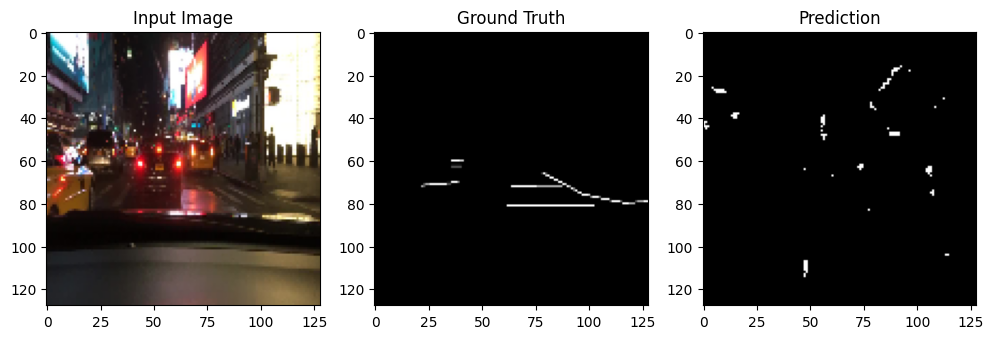

Prediction #6


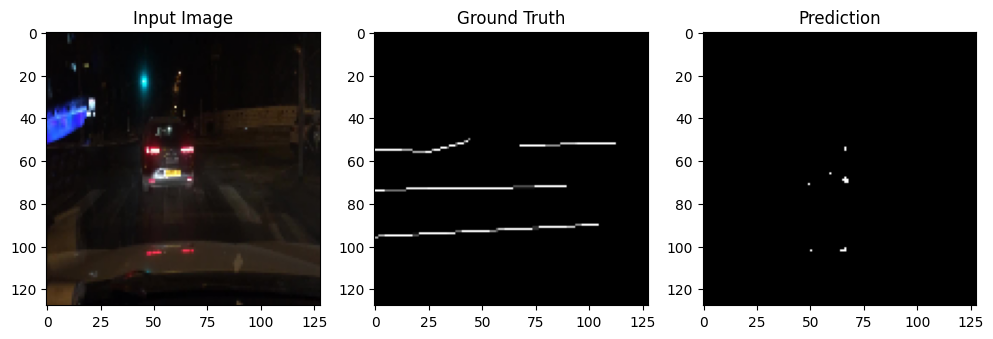

Prediction #7


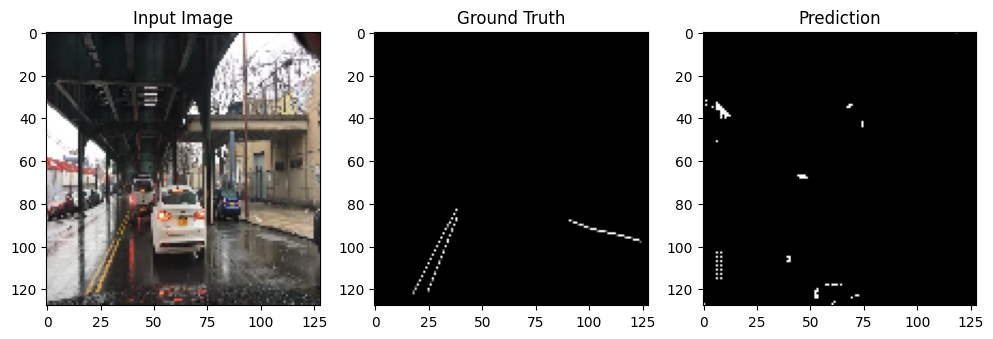

Prediction #8


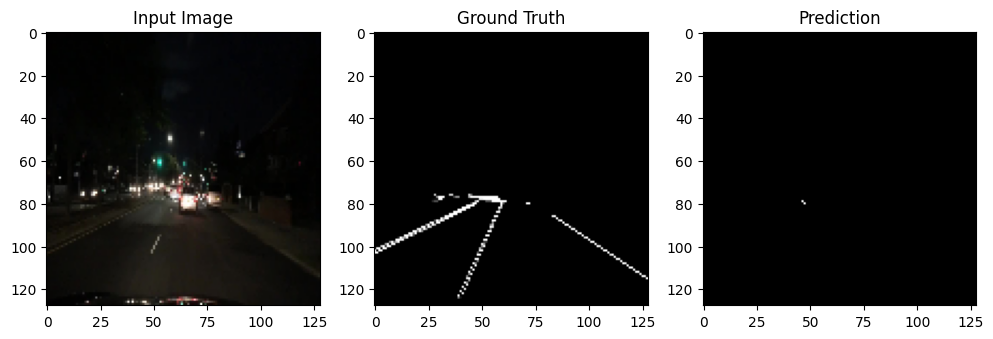

Prediction #9


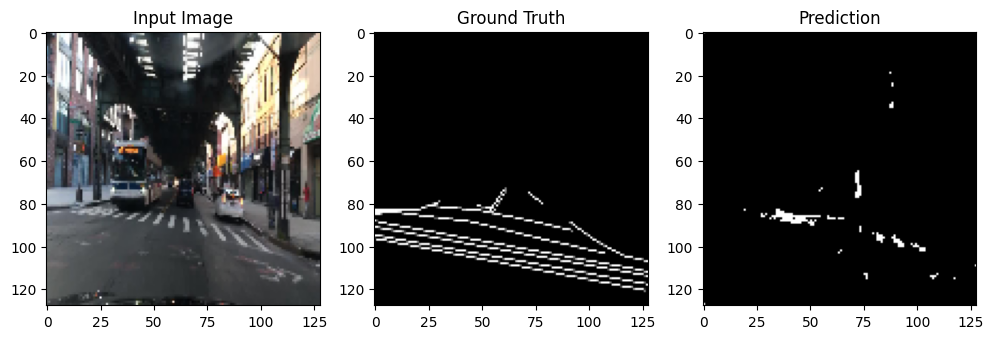

Prediction #10


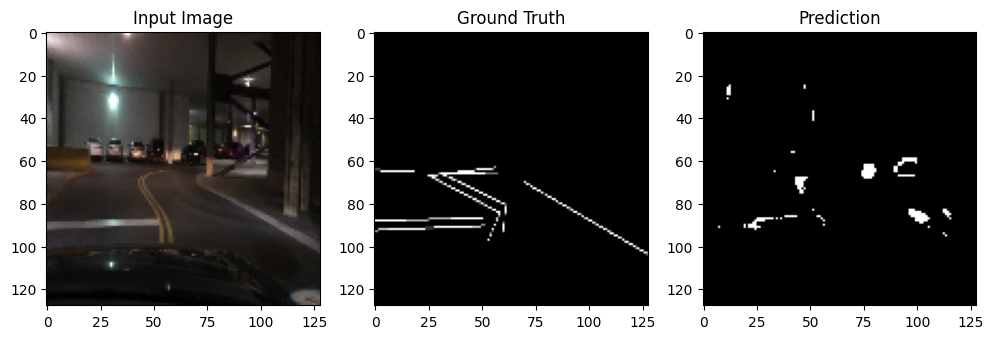

Prediction #11


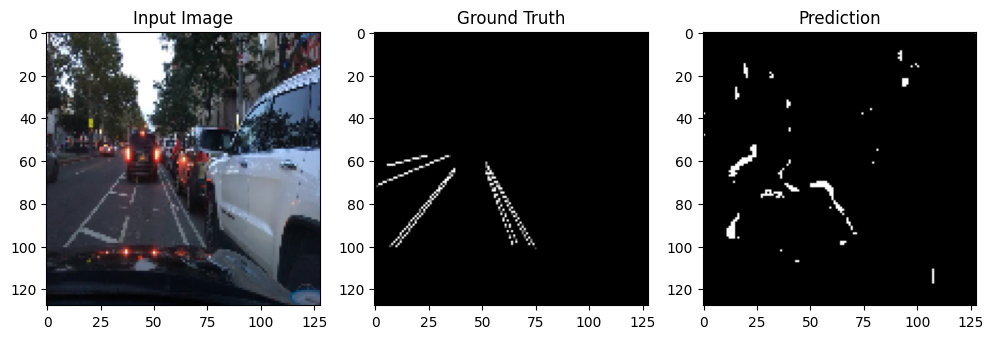

Prediction #12


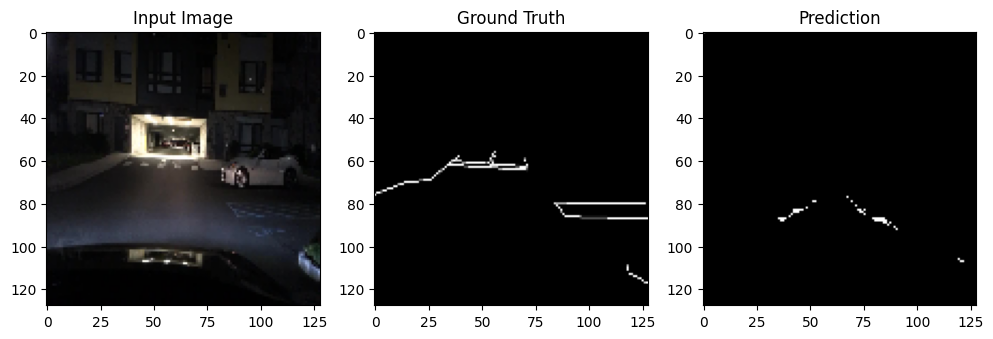

Prediction #13


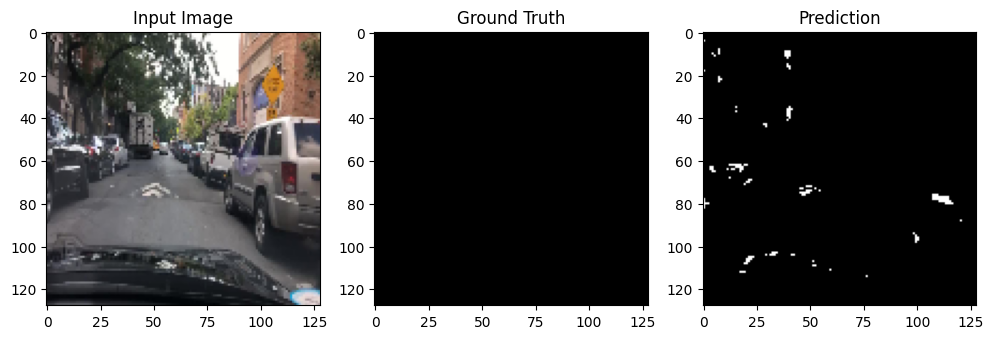

Prediction #14


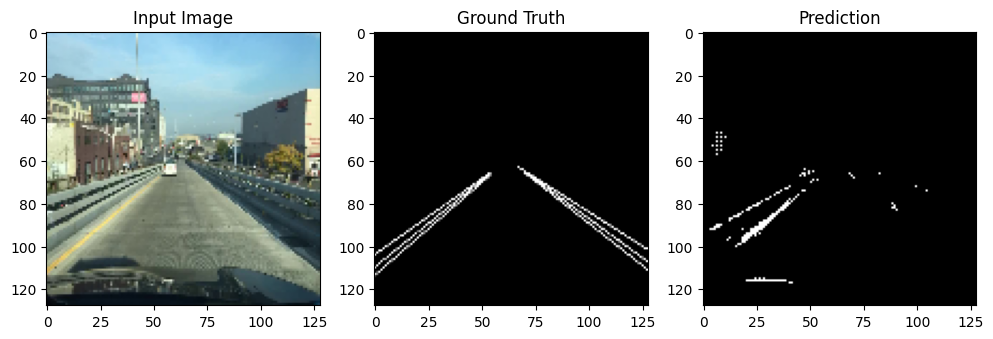

Prediction #15


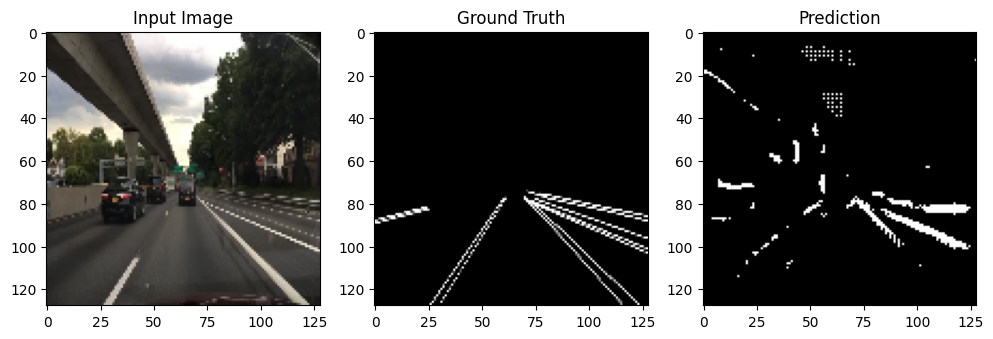

Prediction #16


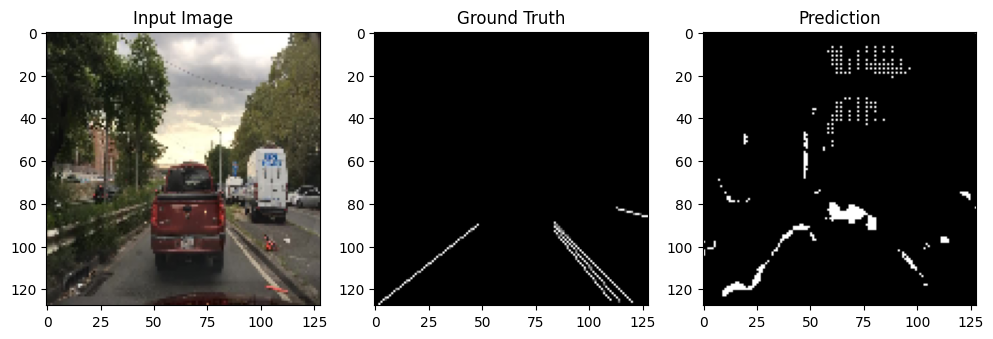

Prediction #17


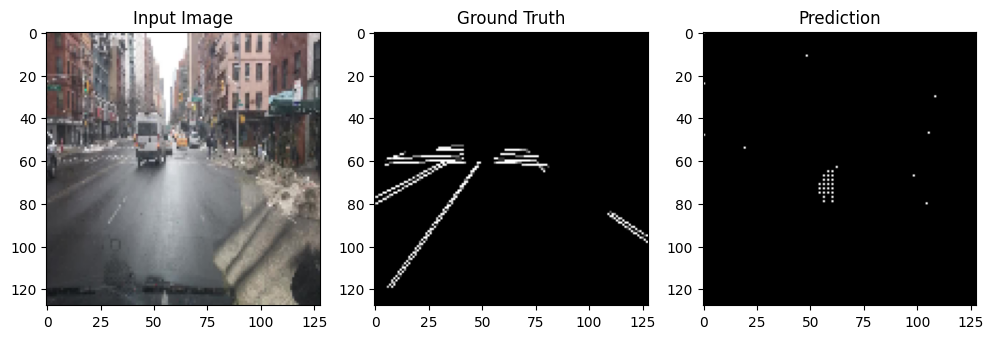

Prediction #18


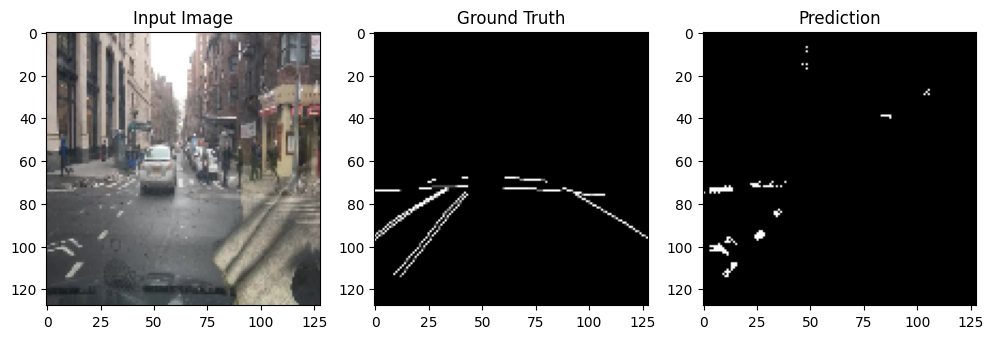

Prediction #19


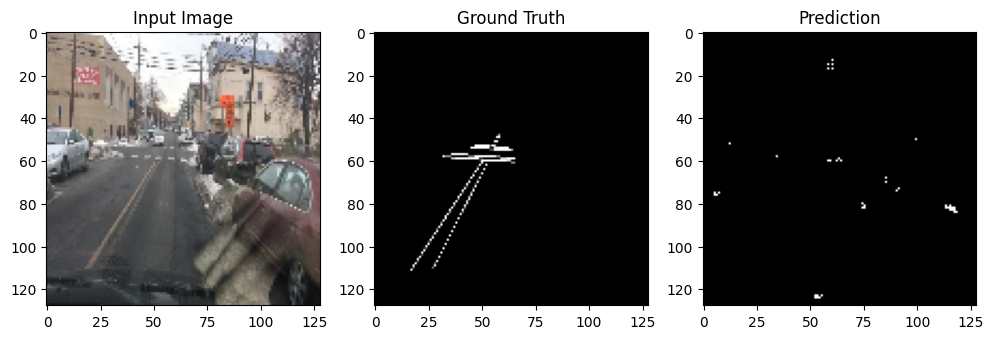

Prediction #20


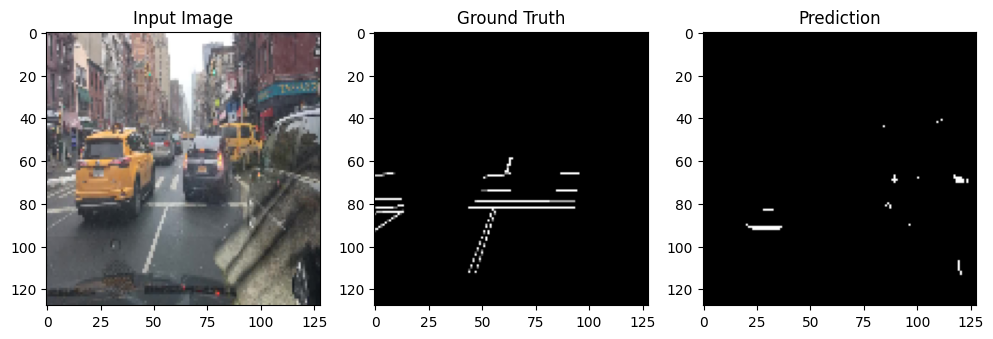

Prediction #21


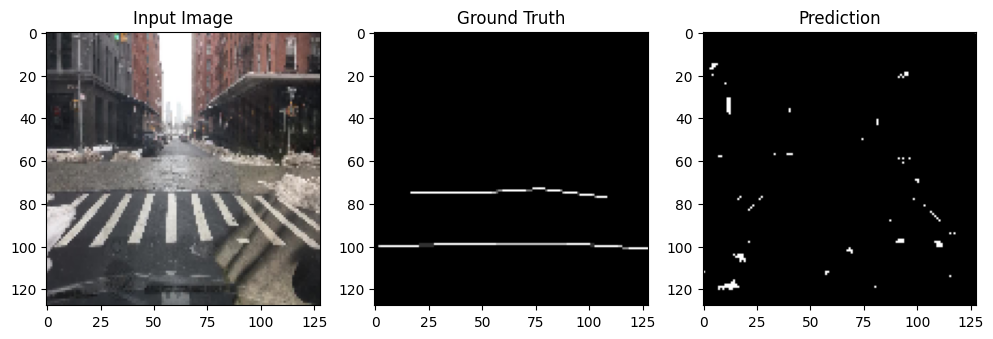

Prediction #22


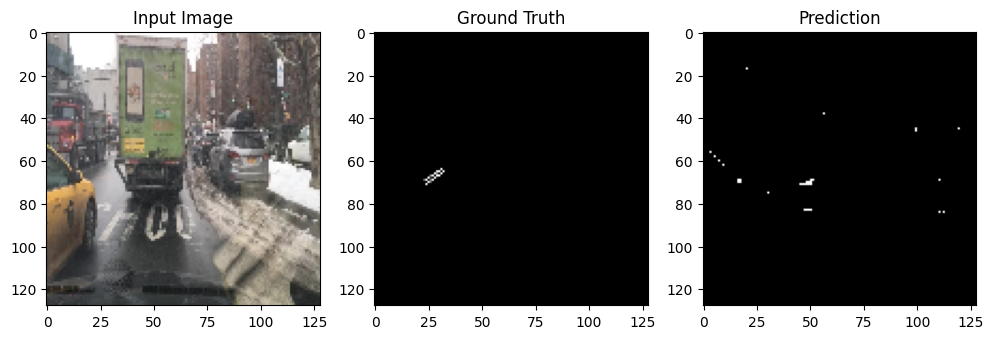

Prediction #23


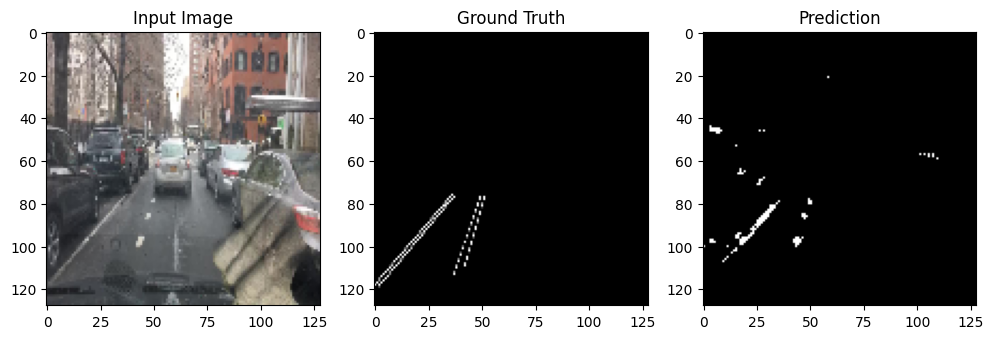

Prediction #24


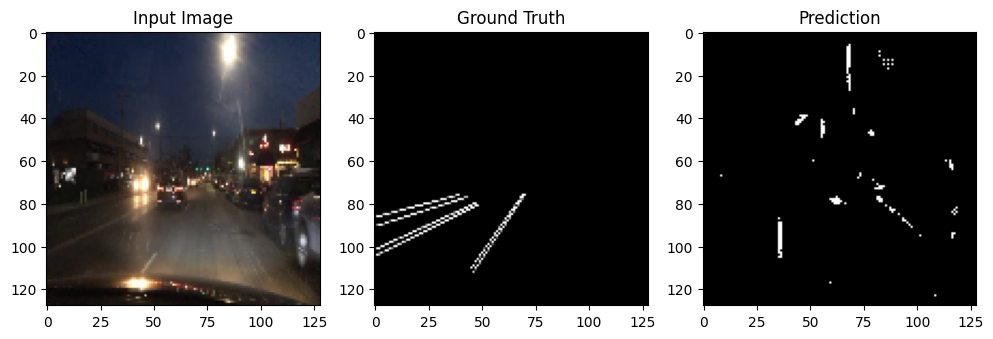

Prediction #25


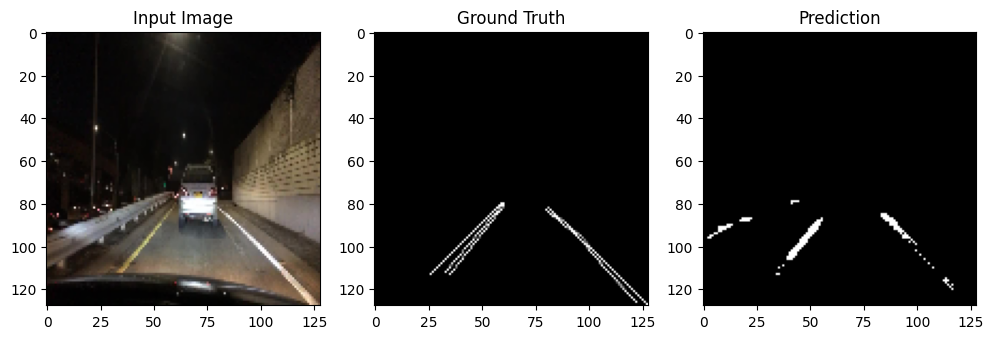

Prediction #26


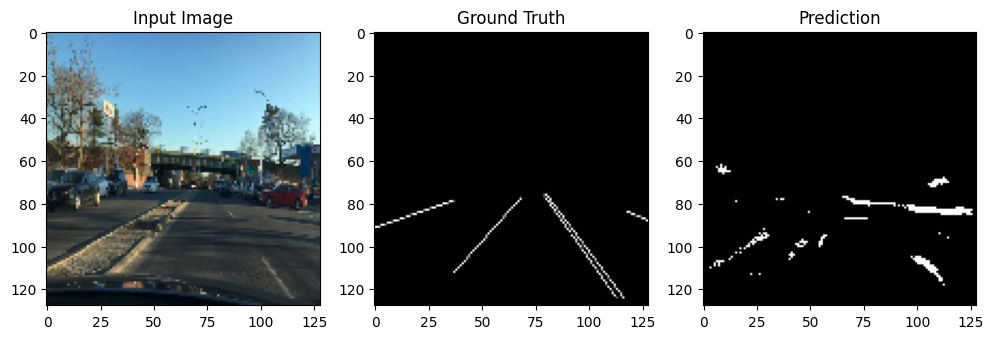

Prediction #27


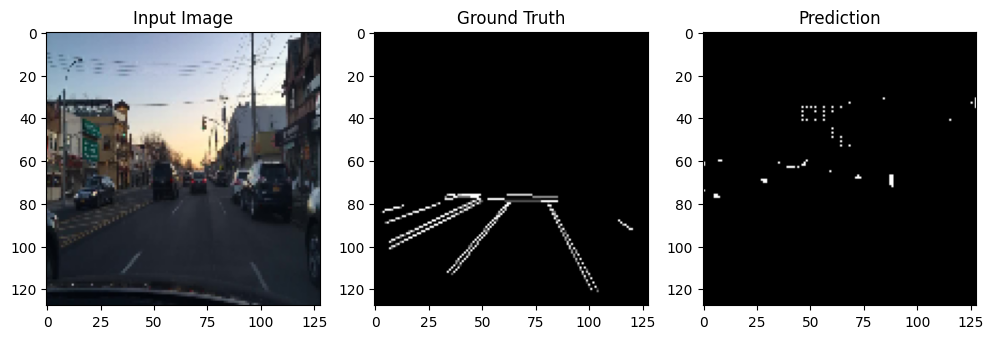

Prediction #28


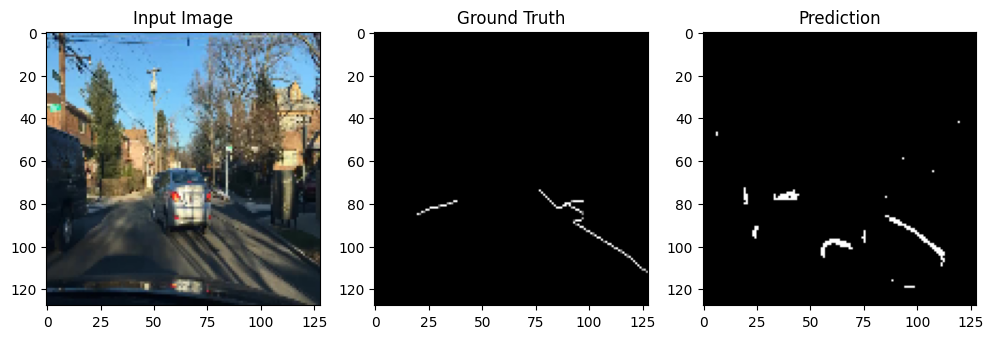

Prediction #29


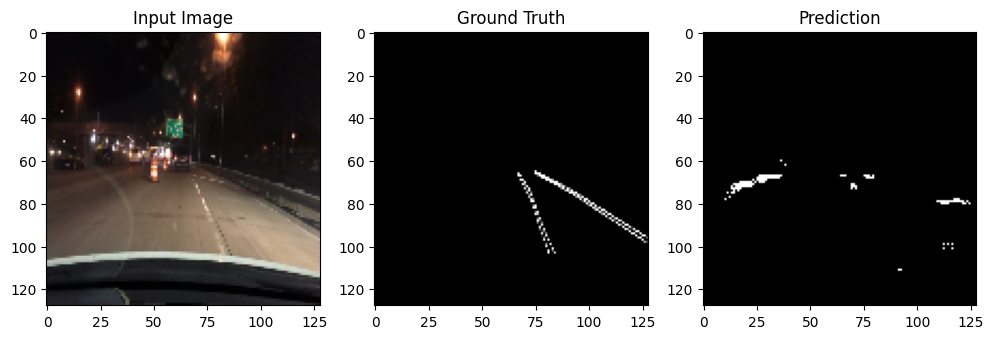

Prediction #30


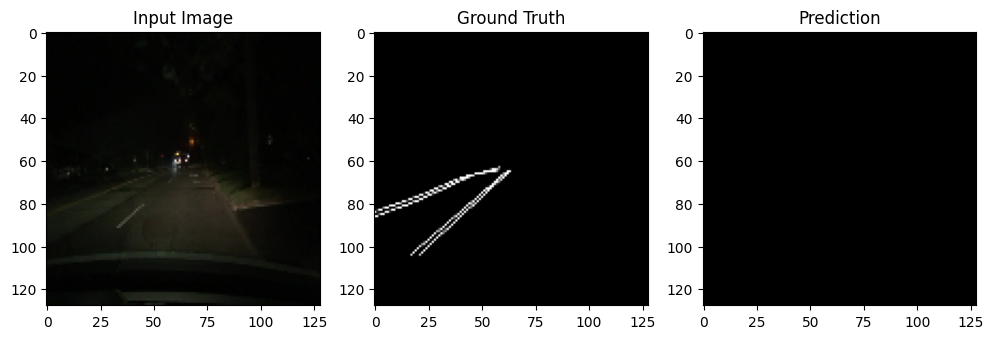

Prediction #31


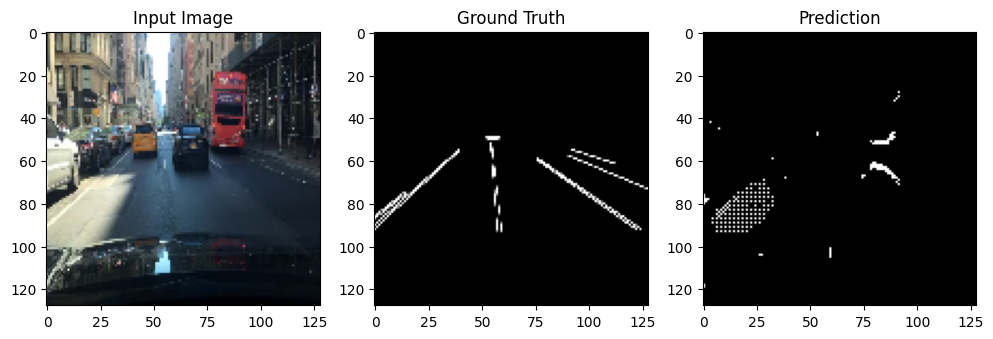

Prediction #32


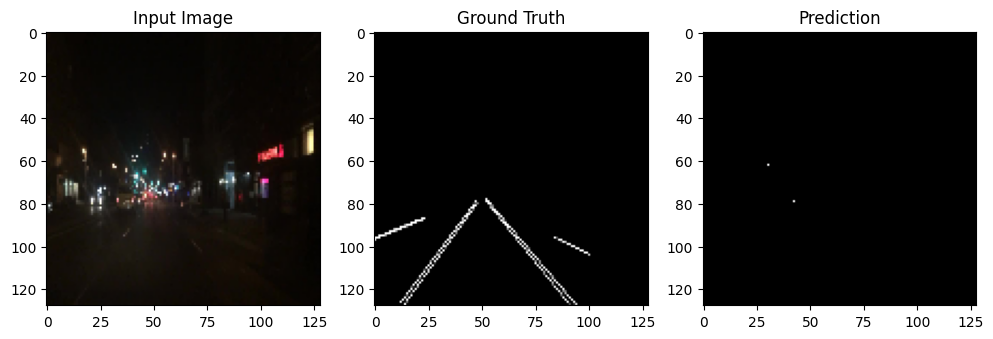

Prediction #33


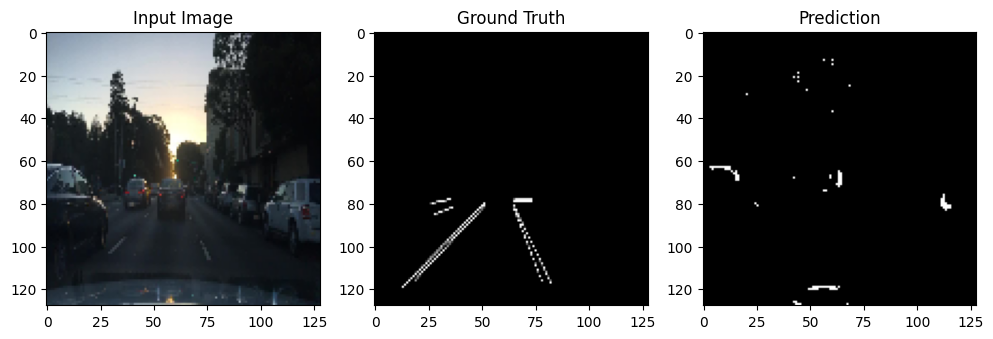

Prediction #34


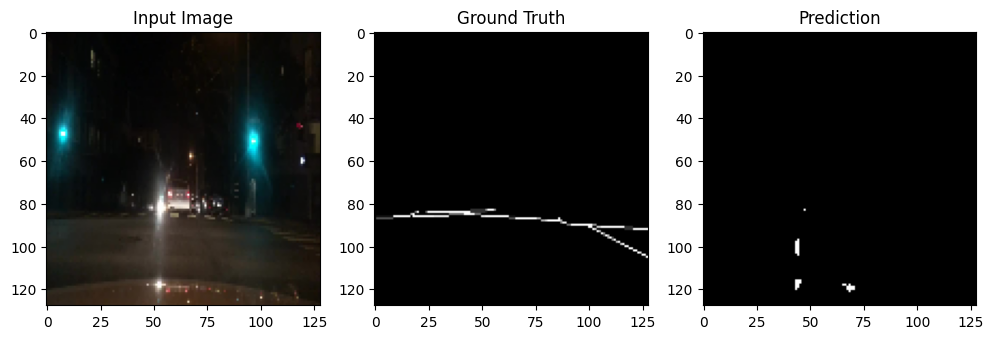

Prediction #35


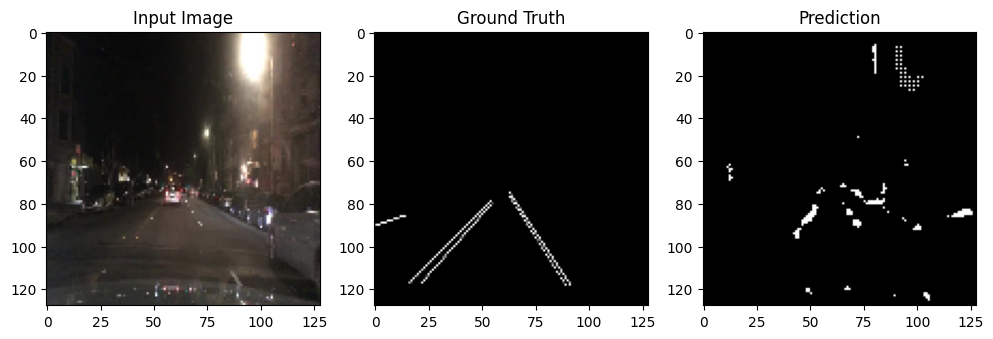

Prediction #36


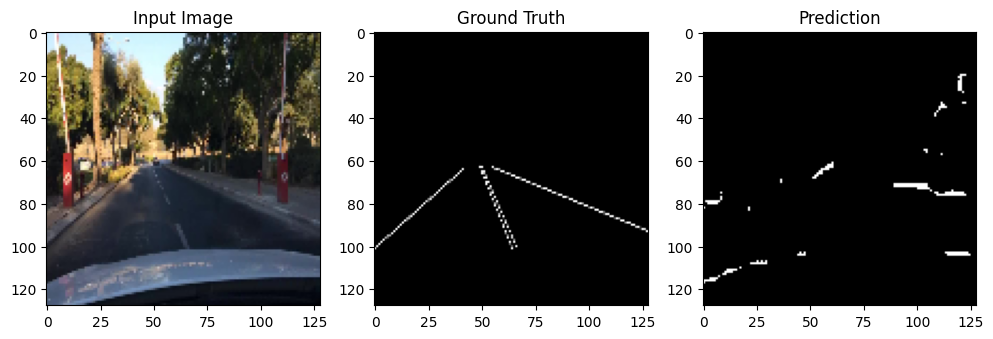

Prediction #37


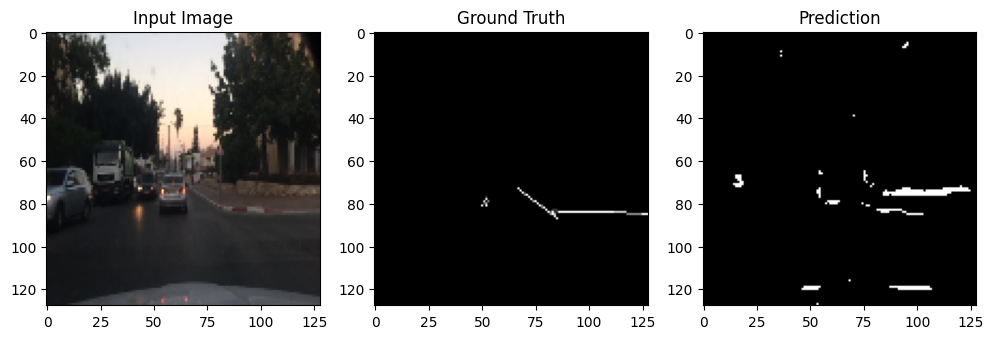

Prediction #38


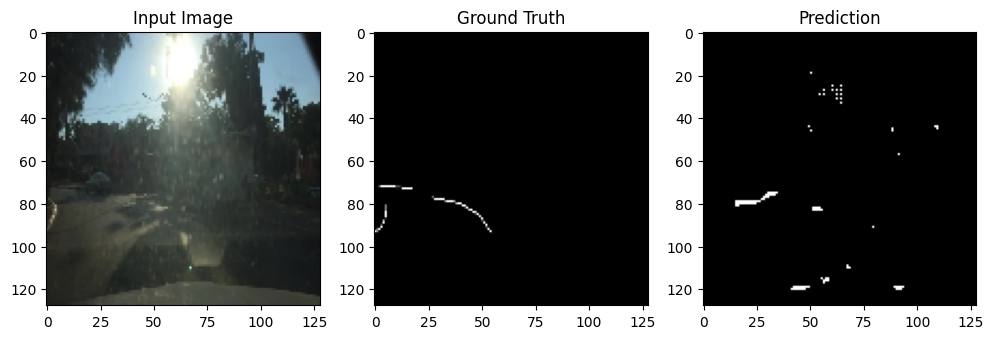

Prediction #39


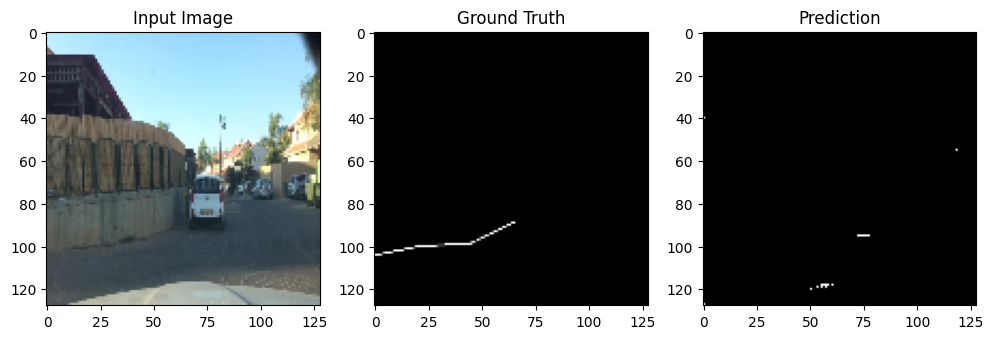

Prediction #40


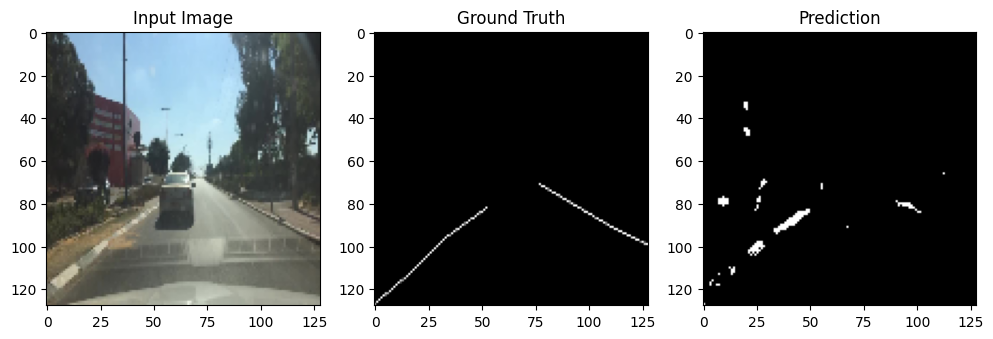

Prediction #41


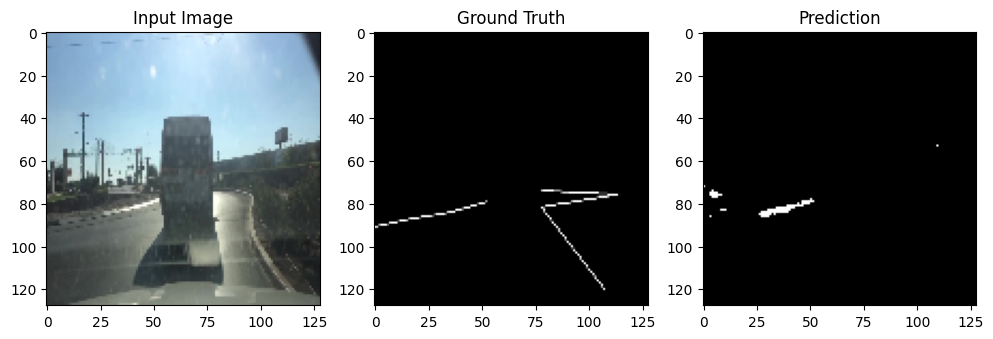

Prediction #42


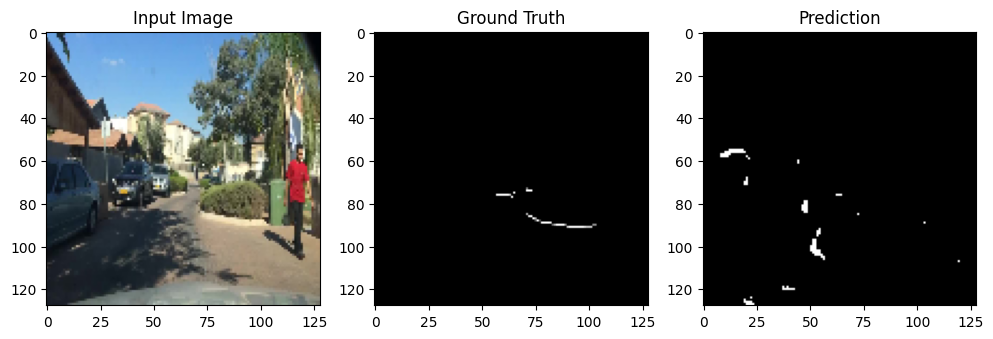

Prediction #43


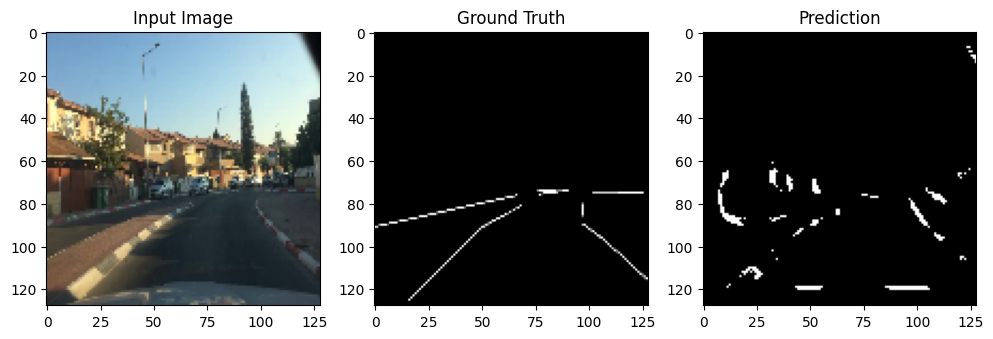

Prediction #44


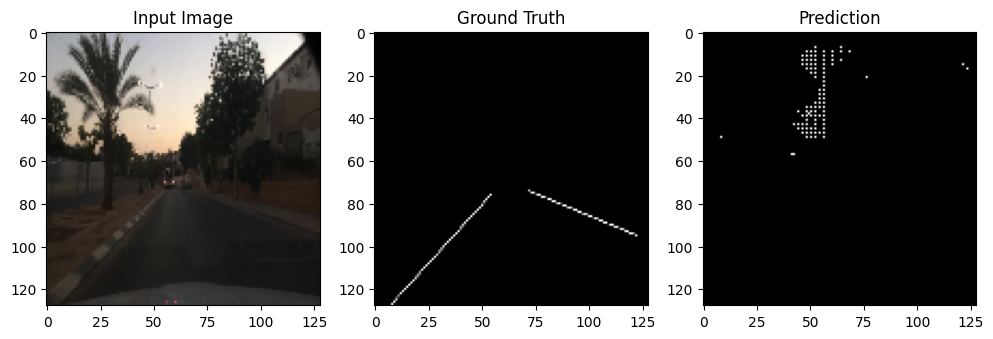

Prediction #45


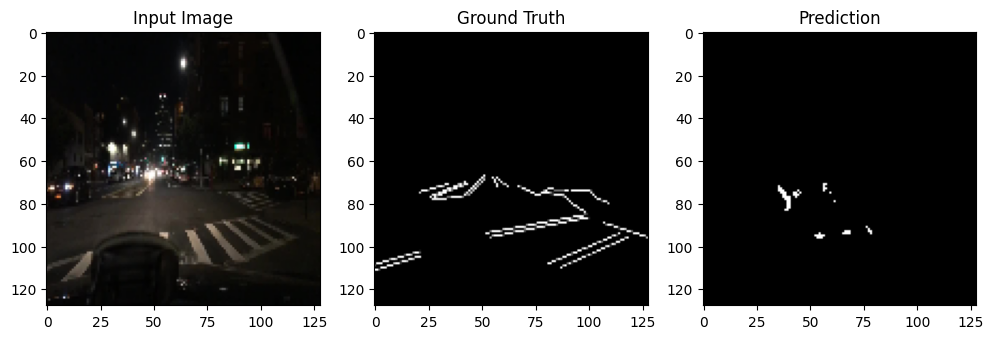

Prediction #46


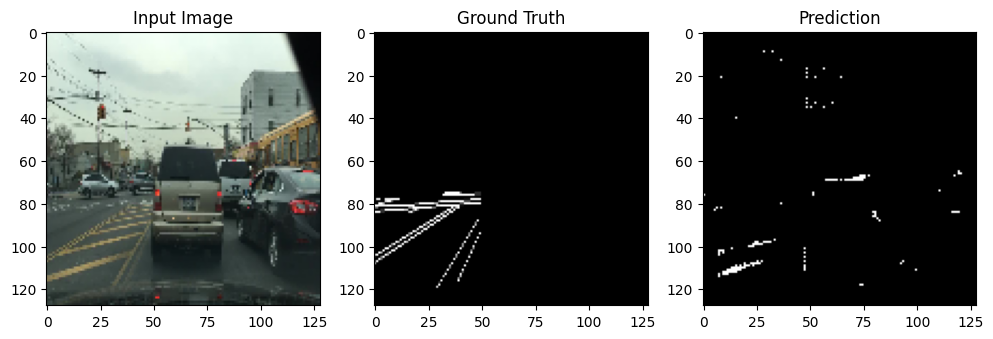

Prediction #47


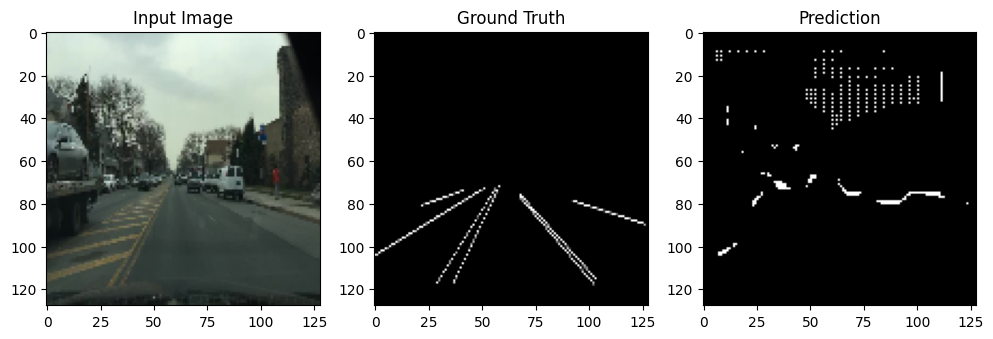

Prediction #48


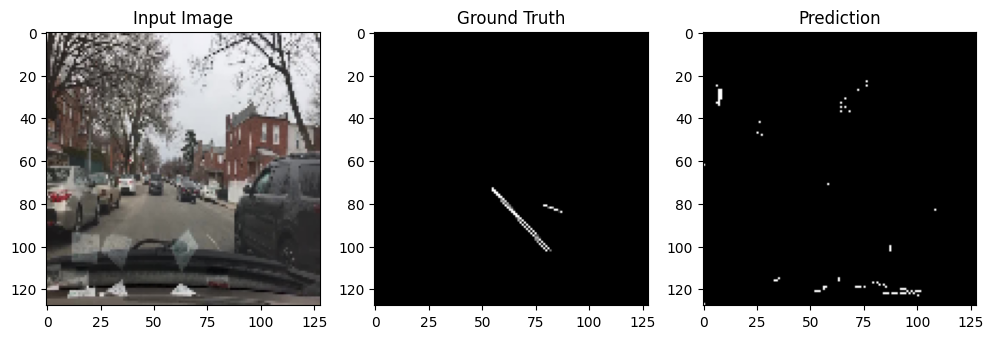

Prediction #49


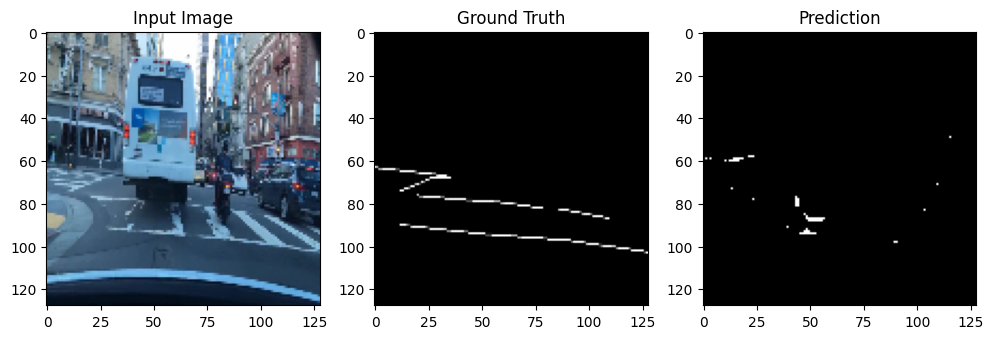

In [45]:
def show_predictions1(model, dataset, device, idx=0, threshold=0.2):
    model.eval()
    img, mask = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).squeeze().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred > threshold, cmap='gray')
    plt.title("Prediction")
    plt.show()
for i in range(len(val_data) - 1):
    print(f"Prediction #{i+1}")
    show_predictions1(model, val_data, device, idx=i)


In [46]:
def compute_iou(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1, 2, 3))
    union = (preds + masks).clamp(0, 1).sum(dim=(1, 2, 3)) - intersection
    return ((intersection + 1e-6) / (union + 1e-6)).mean().item()

def compute_dice(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1, 2, 3))
    return ((2 * intersection + 1e-6) / (preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) + 1e-6)).mean().item()

# Validation Evaluation
model.eval()
iou_total, dice_total = 0, 0
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        iou_total += compute_iou(preds, masks)
        dice_total += compute_dice(preds, masks)

print(f"Mean IoU: {iou_total / len(val_loader):.4f}")
print(f"Mean Dice Score: {dice_total / len(val_loader):.4f}")


Mean IoU: 0.0192
Mean Dice Score: 0.0192


In [47]:
# Save
torch.save(model.state_dict(), '/content/drive/MyDrive/lane_segmentation_unet.pth')

# Load later
model = UNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/lane_segmentation_unet.pth'))


<All keys matched successfully>

In [76]:
def predict_on_external_image(image_path, model, device):
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img.copy()

    img = cv2.resize(img, (128, 128))  # or 256x256 if you trained that way
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img).squeeze().cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(pred > 0.19, cmap='gray')
    plt.title("Predicted Lane Mask")
    plt.show()


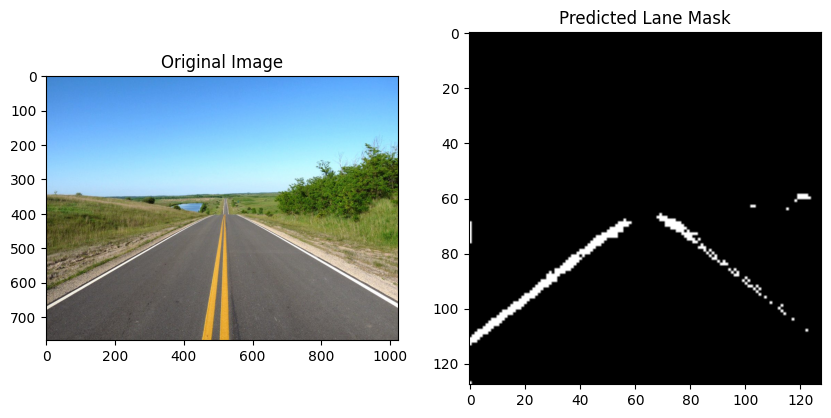

In [77]:
predict_on_external_image("/content/l1.jpg.crdownload", model, device)


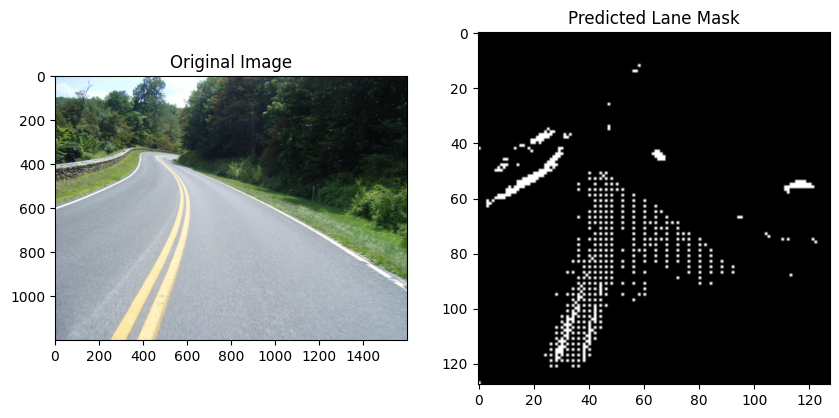

In [78]:
predict_on_external_image("/content/l2.JPG.crdownload", model, device)

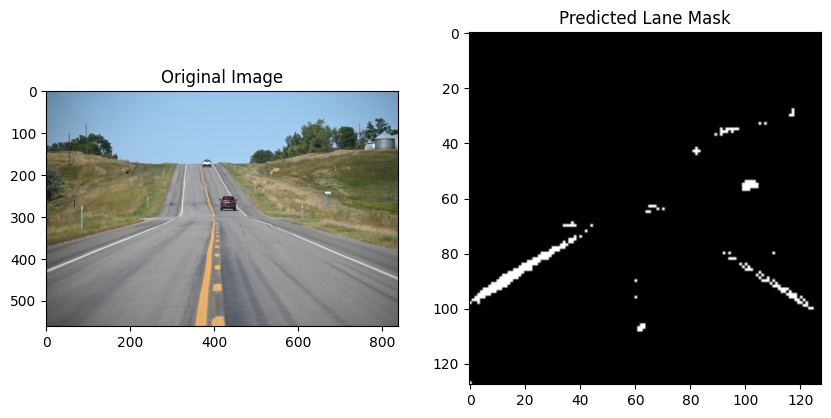

In [79]:
predict_on_external_image("/content/l3.jpeg", model, device)

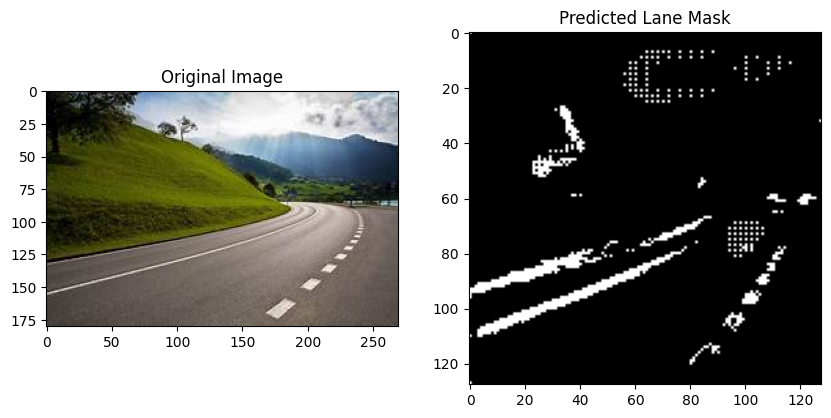

In [80]:
predict_on_external_image("/content/l4.jpeg", model, device)

In [ ]:
predict_on_external_image("", model, device)